In [30]:
pip install --upgrade google-meridian

Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import input_data
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 8.6 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [45]:
pddata = pd.read_csv('dataset/mock_mmm_data.csv')

In [46]:
coord_to_columns = load.CoordToColumns(
    time='date',
    controls=['percent_share_of_sales_value_product', 'competitor_KTD_S', 'competitor_Carabao_S'],
    kpi='total_sales',
    media=[
        'kol_S',
        'tv_spot_S',
        'tv_sponsor_S',
        'radio_S',
        'activation_S',
        'facebook_S',
        'youtube_S',
        'tiktok_S',
        'kol_boost_S'
    ],
    media_spend=[
        'kol_S',
        'tv_spot_S',
        'tv_sponsor_S',
        'radio_S',
        'activation_S',
        'facebook_S',
        'youtube_S',
        'tiktok_S',
        'kol_boost_S'
    ],
)

In [47]:
correct_media_to_channel = {
        'kol_S': 'kol',
        'tv_spot_S': 'tv_spot',
        'tv_sponsor_S': 'tv_sponsor',
        'radio_S': 'radio',
        'activation_S': 'activation',
        'facebook_S': 'facebook',
        'youtube_S': 'youtube',
        'tiktok_S' : 'tiktok',
        'kol_boost_S': 'kol_boost'
}

correct_media_spend_to_channel = {
        'kol_S': 'kol',
        'tv_spot_S': 'tv_spot',
        'tv_sponsor_S': 'tv_sponsor',
        'radio_S': 'radio',
        'activation_S': 'activation',
        'facebook_S': 'facebook',
        'youtube_S': 'youtube',
        'tiktok_S' : 'tiktok',
        'kol_boost_S': 'kol_boost'
}

In [48]:
loader = load.CsvDataLoader(
    csv_path=f'dataset/mock_mmm_data.csv',
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_spend_to_channel,
)

data = loader.load()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/data/input_data.py:463: UserWarning: Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.
  warnings.warn(


In [49]:
#functiom to translate the media ROI into a log normal distribution usable by the model prios

def estimate_lognormal_dist(mean, std):
    """
    Reparameterizes the LogNormal distribution in terms of its mean and std.
    Returns mu_log and std_log which can be used to define a LogNormal.
    """
    mu_log = np.log(mean) - 0.5 * np.log((std/mean)**2 + 1)
    std_log = np.sqrt(np.log((std/mean)**2 + 1))
    return mu_log, std_log

roi_mu= 5
roi_sigma= 4.5

roi_mu_log, roi_sigma_log=estimate_lognormal_dist(roi_mu, roi_sigma)
print(roi_mu_log, roi_sigma_log)

pddata = pd.read_csv('dataset/mock_mmm_data.csv')

# setting priors based on spend share
total_spend= pddata[['kol_S', 'tv_spot_S', 'tv_sponsor_S', 'radio_S', 'activation_S', 'facebook_S', 'youtube_S', 'tiktok_S', 'kol_boost_S']].sum().sum()
priors={'mu':[], 'sigma':[]}
for i in ['kol_S', 'tv_spot_S', 'tv_sponsor_S', 'radio_S', 'activation_S', 'facebook_S', 'youtube_S', 'tiktok_S', 'kol_boost_S']:
  spend_share=(pddata[i].sum()/total_spend)*2
  roi_sigma=roi_mu*spend_share
  mu , sigma= estimate_lognormal_dist(roi_mu, roi_sigma)
  priors['mu'].append(mu)
  priors['sigma'].append(sigma)

print(priors)

roi_mu=priors['mu']
roi_sigma=priors['sigma']
print(roi_mu)


1.3127744897952331 0.7702771223902047
{'mu': [np.float64(1.5839483426707204), np.float64(1.494084943302392), np.float64(1.6093190990029684), np.float64(1.5986502233983582), np.float64(1.4680224181822228), np.float64(1.5619938099859194), np.float64(1.5910619655217), np.float64(1.6094191749211793), np.float64(1.6093662127243575)], 'sigma': [np.float64(0.22578560522486787), np.float64(0.48031857996897914), np.float64(0.015415150413267882), np.float64(0.1468855951803458), np.float64(0.5318185672800029), np.float64(0.308039291156764), np.float64(0.1917078345420458), np.float64(0.006121684885890533), np.float64(0.011974949665258191)]}
[np.float64(1.5839483426707204), np.float64(1.494084943302392), np.float64(1.6093190990029684), np.float64(1.5986502233983582), np.float64(1.4680224181822228), np.float64(1.5619938099859194), np.float64(1.5910619655217), np.float64(1.6094191749211793), np.float64(1.6093662127243575)]


In [50]:
# Convert numpy float64 values to TensorFlow float32 tensors
roi_mu = [tf.convert_to_tensor(m, dtype=tf.float32) for m in roi_mu]
roi_sigma = [tf.convert_to_tensor(s, dtype=tf.float32) for s in roi_sigma]

# Build media channel arguments
build_media_channel_args = data.get_paid_media_channels_argument_builder()

# Pass the converted tensors
roi_m = build_media_channel_args(
    kol=(roi_mu[0], roi_sigma[0]),
    tv_spot=(roi_mu[1], roi_sigma[1]),
    tv_sponsor=(roi_mu[2], roi_sigma[2]),
    radio=(roi_mu[3], roi_sigma[3]),
    activation=(roi_mu[4], roi_sigma[4]),
    facebook=(roi_mu[5], roi_sigma[5]),
    youtube=(roi_mu[6], roi_sigma[6]),
    tiktok=(roi_mu[7], roi_sigma[7]),
    kol_boost=(roi_mu[8], roi_sigma[8]),
)

roi_m_mu, roi_m_sigma = zip(*roi_m)

# Convert to TensorFlow tensors
roi_m_mu = tf.stack(roi_m_mu)
roi_m_sigma = tf.stack(roi_m_sigma)

# Create prior distribution
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_m_mu, roi_m_sigma, name=constants.ROI_M),
)

In [51]:
np.random.seed(1)
test_pct = 0.2  # 20% holdout
n_times = len(data.time)

# Create a 1D boolean array of length n_times
holdout_id = np.full(n_times, False)
holdout_indices = np.random.choice(n_times, int(np.round(test_pct * n_times)), replace=False)
holdout_id[holdout_indices] = True

# Pass it into the model spec
model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout_id
)


In [52]:
#%%time

mmm = model.Meridian(input_data=data, model_spec=model_spec)
mmm.sample_prior(500)
#It tells the function to generate 500 samples from the prior distribution.x



from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import time

# ... (rest of your imports and code) ...

with tqdm(total=5*1000, desc="Training Progress") as pbar:  # Total iterations
    def update_progress(current_iteration, total_iterations):
        pbar.update(current_iteration)  # Update the progress bar

    # Remove progress_callback from the sample_posterior call
    mmm.sample_posterior(
        n_chains=5,
        n_adapt=500,
        n_burnin=500,
        n_keep=1000,
        parallel_iterations=100,
        # progress_callback=update_progress  # Remove this line
    )
    # Manually update progress bar after sampling
    pbar.update(5 * 1000)

#n_chains: Markov Chain Monte Carlo (MCMC) indipendent chains
#n_adapt: number of initial samples used to tune the sampling algorithm for better performance
#n_burnin: number of initial samples from each chain that are discarded
#n_keep: number of samples to keep from each chain after the burn-in phase. These samples represent the posterior distribution of the model parameters and are used for inference.

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution par

Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

W0000 00:00:1752518589.296726 1145971 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


In [53]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

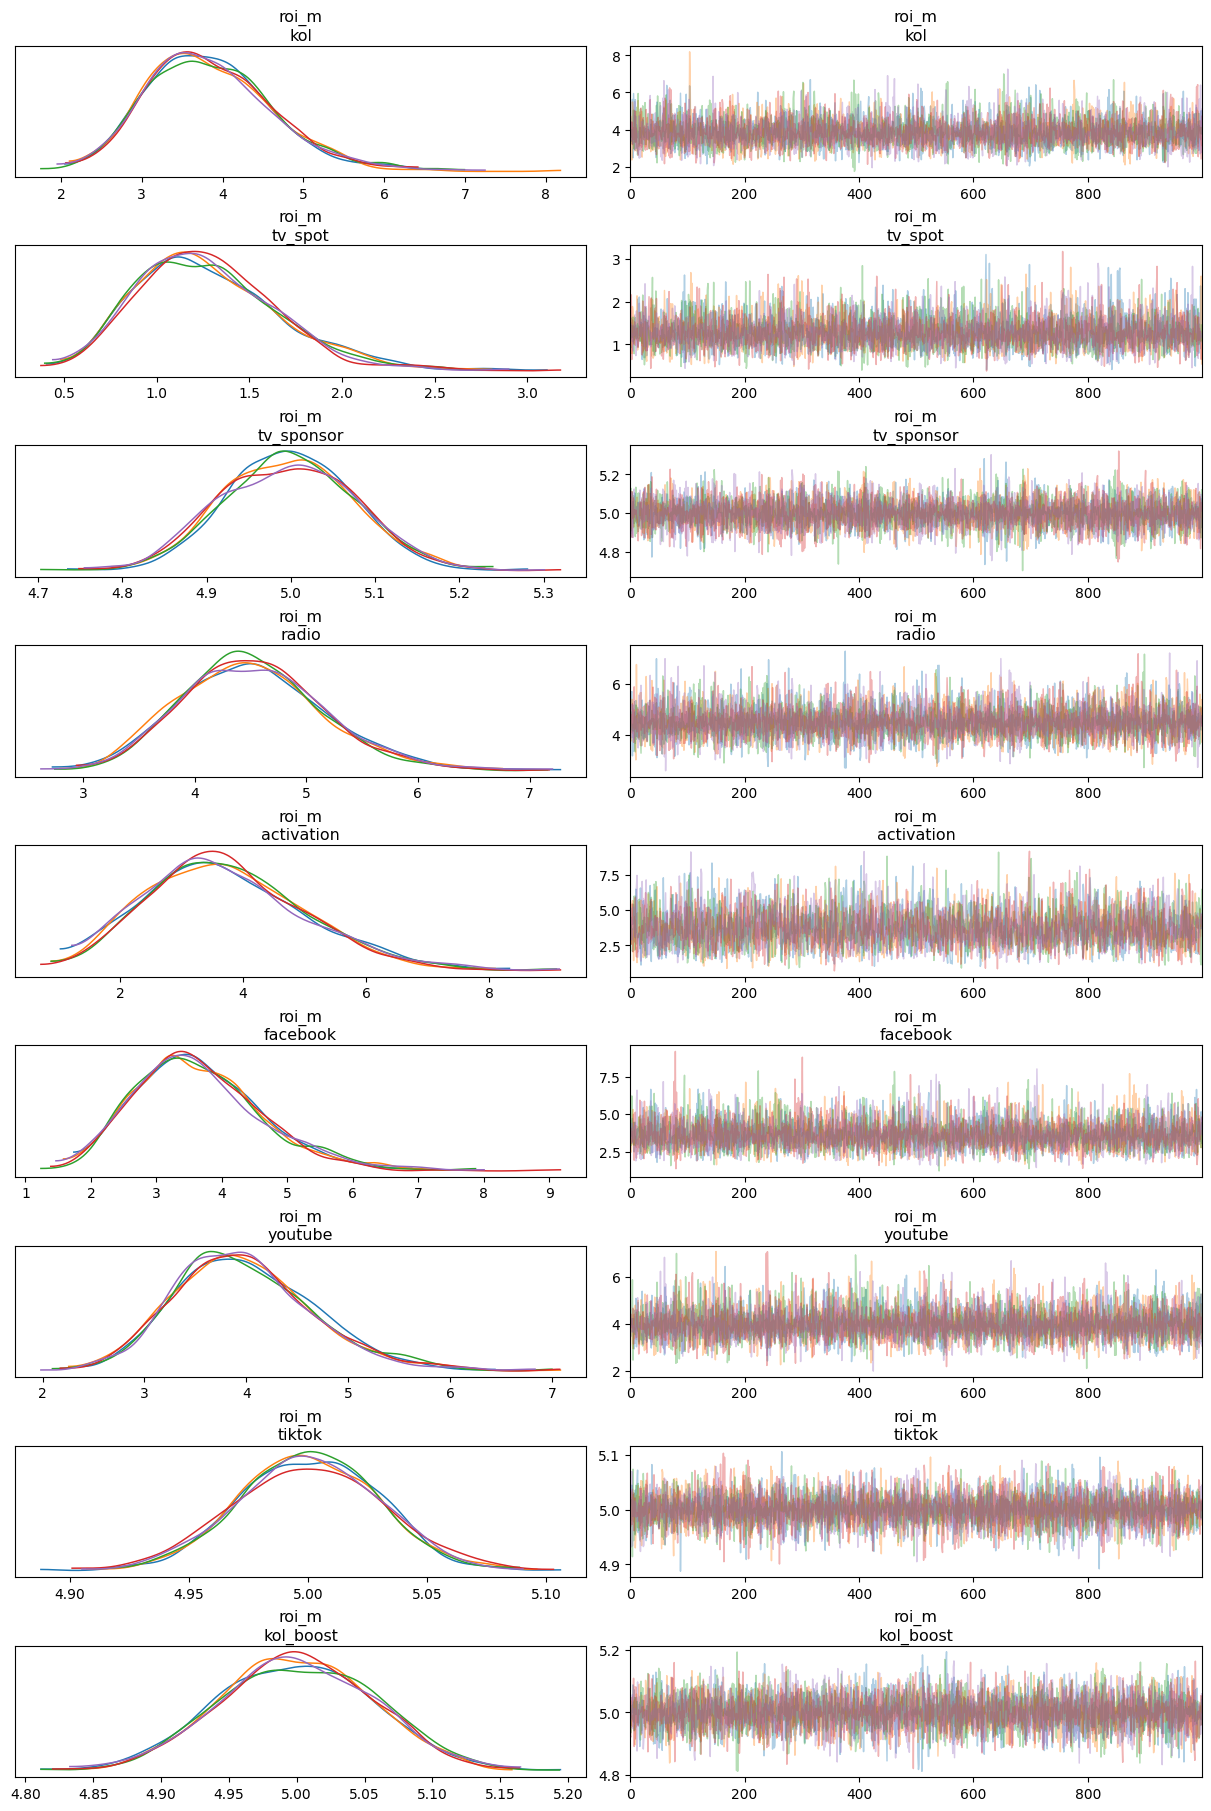

In [54]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [55]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_prior_and_posterior_distribution()

alt.FacetChart(...)

In [56]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [57]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/Users/plansuraamornkul/miniconda3/lib/python3.12/site-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


metric geo_granularity evaluation_set     value
0  R_Squared        national          Train  0.942697
1  R_Squared        national           Test  0.809399
2  R_Squared        national       All Data  0.933324
3       MAPE        national          Train  1.754770
4       MAPE        national           Test  0.131187
5       MAPE        national       All Data  1.426932
6      wMAPE        national          Train  0.112983
7      wMAPE        national           Test  0.116690
8      wMAPE        national       All Data  0.113931

In [ ]:
filepath = './output'  # or any local directory you want
start_date = '2022-07-04'
end_date = '2024-06-24'

mmm_summarizer = summarizer.Summarizer(mmm)

# Make sure the directory exists
import os
os.makedirs(filepath, exist_ok=True)

mmm_summarizer.output_model_results_summary('new_summary_output.html', filepath, start_date, end_date)

# To display in VS Code Jupyter notebook output
#from IPython.display import HTML
#HTML(filename=os.path.join(filepath, 'summary_output.html'))
